<a href="https://colab.research.google.com/github/vatsalkachhia/Image-classifier-deployment-flask/blob/master/Transfer_learning_image_classifire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp /content/drive/MyDrive/projects/classification/data.zip /content/

In [2]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/image1938.jpg  
  inflating: dataset/train/image7383.jpg  
  inflating: dataset/train/image5498.jpg  
  inflating: dataset/train/image6955.jpg  
  inflating: dataset/train/image4840.jpg  
  inflating: dataset/train/image2695.jpg  
  inflating: dataset/train/image524.jpg  
  inflating: dataset/train/image1074.jpg  
  inflating: dataset/train/image3524.jpg  
  inflating: dataset/train/image3570.jpg  
  inflating: dataset/train/image8561.jpg  
  inflating: dataset/train/image5242.jpg  
  inflating: dataset/train/image567.jpg  
  inflating: dataset/train/image8431.jpg  
  inflating: dataset/train/image529.jpg  
  inflating: dataset/train/image5156.jpg  
  inflating: dataset/train/image6005.jpg  
  inflating: dataset/train/image6678.jpg  
  inflating: dataset/train/image9808.jpg  
  inflating: dataset/train/image1214.jpg  
  inflating: dataset/train/image6836.jpg  
  inflating: dataset/train/image949.jpg  
  infla

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [4]:
img = plt.imread("dataset/train/image5607.jpg")
img.shape


(53, 80, 3)

##training data analisys

In [5]:
train_data = pd.read_csv('/content/dataset/train.csv')
classes = set(train_data['Class'])


In [6]:
train_data.groupby(['Class']).count()

,Image
Class,
Airplane,535
Candle,593
Christmas_Tree,1539
Jacket,640
Miscellaneous,2801
Snowman,361


Train dev split through folder

In [7]:
import shutil
import os

In [8]:
def make_dirs(path, classes):
    """
    Make directorys according to classes in input
    path -> input path
    classes -> an iterable including all the classes
    """
    if not os.path.exists(path):
        try:
            os.mkdir(path)
        except Exception as e:
            print(e)
        
    for lable in classes:
        try:
            os.mkdir(os.path.join(path,lable))
        except Exception as e:
            print(e)
        


In [9]:
def shift_data( input_dir, dataframe_input, classes , output_folder):
    make_dirs(output_folder, classes)
    for img, lable in dataframe_input.values:
        try :
            shutil.copy(os.path.join(input_dir, img),
                        os.path.join(output_folder, lable, img))
        except Exception as e:
            print(e, f"Lable : {lable}")

    
        

In [10]:
shift_data( '/content/dataset/train', train_data, classes, "/content/shifted_dataset")


In [11]:
!pip install split-folders tqdm

In [12]:
import splitfolders

In [13]:
splitfolders.ratio("/content/shifted_dataset", output="/content/dataset_splits", seed=1337, ratio=(.8, .2), group_prefix=None) # default values


Copying files: 6469 files [00:00, 9590.19 files/s]


##creating data generators

In [14]:
train_dir = "/content/dataset_splits/train"
val_dir = "/content/dataset_splits/val"


img_size = (299, 299)
batch_size = 64

In [15]:
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            ).flow_from_directory(
                val_dir, 
                seed=123,
                shuffle = False,
                target_size= img_size,
                batch_size=1296)

Found 1296 images belonging to 6 classes.


In [16]:
val_data = next(val_gen)
val_data[0].shape


(1296, 299, 299, 3)

In [17]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_dir,
                                       target_size= img_size,
                                       batch_size= batch_size,
                                       class_mode='categorical',
                                       shuffle = True,
                                       seed = 123)

Found 5173 images belonging to 6 classes.


In [18]:
val_gen.class_indices == train_gen.class_indices

True

In [19]:
class_to_id = {train_gen.class_indices[x]:x for x in train_gen.class_indices}

In [20]:
def display_examples(id_to_class, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(id_to_class[labels[i]])
    plt.show()

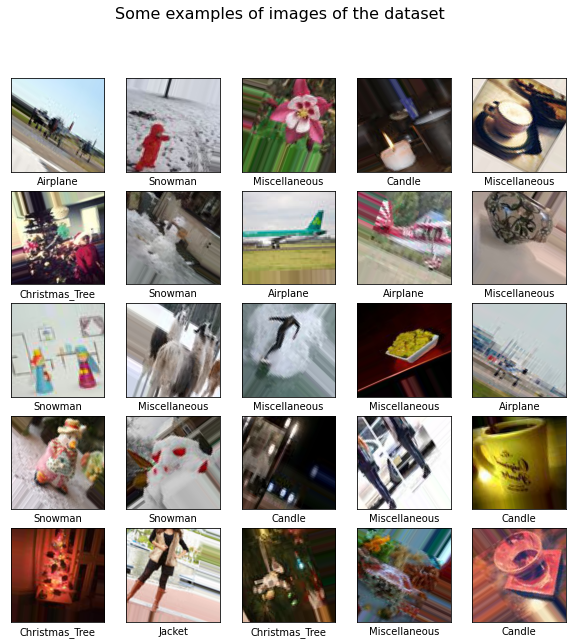

In [27]:
#display val data
images, labels= next(train_gen)
display_examples(class_to_id, images, labels.argmax(axis=1))

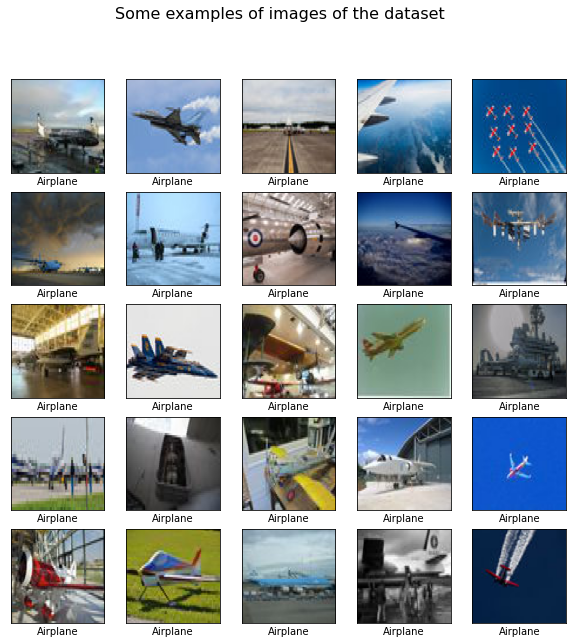

In [26]:
#display val data
display_examples(class_to_id, val_data[0], val_data[1].argmax(axis=1))

In [ ]:
#temp_img,temp_lable= next(train_gen)

Miscellaneous


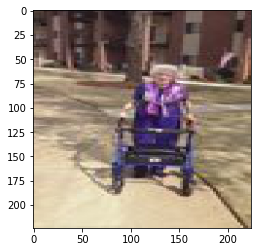

In [ ]:
#choice = np.random.randint(0,batch_size)
#print(class_to_id[temp_lable[choice].argmax()])
#plt.imshow(temp_img[choice])

In [ ]:
#temp_lable.argmax(axis=1)

array([4, 4, 2, 4, 3, 2, 4, 4, 0, 4, 2, 2, 0, 0, 2, 4, 4, 4, 1, 1, 1, 2,
       3, 3, 4, 2, 4, 4, 3, 1, 3, 4, 2, 2, 4, 0, 4, 2, 2, 4, 3, 4, 0, 4,
       3, 4, 4, 4, 4, 1, 4, 3, 2, 3, 4, 2, 4, 5, 1, 2, 0, 4, 2, 4])

##Creating model

In [ ]:
def crate_model():
    inception = tf.keras.applications.InceptionResNetV2(
        include_top=True,
        weights="imagenet",
        classes=1000,
        classifier_activation="softmax",
    )
    inception.trainable = False
    base_inputs = inception.layers[0].input
    base_output = inception.layers[-2].output
    dropout_1 = tf.keras.layers.Dropout(0.2)(base_output)
    layer1 = tf.keras.layers.Dense(1024,activation="relu")(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2)(layer1)
    layer2 = tf.keras.layers.Dense(1024,activation="relu")(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2)(layer2)
    final_layer = tf.keras.layers.Dense(6,activation="softmax")(dropout_3)

    return tf.keras.Model(inputs = base_inputs, outputs=final_layer)
    




In [ ]:
def get_callbacks(ckpt_dir = "/content/drive/MyDrive/projects/classification/assets/ckpt1000/",
                    tb_dir = "/content/drive/MyDrive/projects/classification/assets/tb_logs1000/"):


    #for reducing lr
    callback_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.0001,
                                verbose=1)
    #for check point
    callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
                            ckpt_dir,
                            monitor='val_acc', 
                            verbose=1, 
                            save_best_only=True,
                            save_weights_only=False, 
                            mode='auto', 
                            save_freq='epoch',
                        )
    #tensorboard
    callback_tb = tf.keras.callbacks.TensorBoard(
                    log_dir=tb_dir , histogram_freq=0, write_graph=True,
                    )
    #tf.keras.callbacks.TensorBoard(
    #                log_dir=tb_dir, 
    #                histogram_freq=1, 
    #                write_graph=True,
    #                update_freq='epoch'
    #            )
    return [callback_tb,callback_lr,callback_ckpt]

In [ ]:
steps_per_epoch = int(5173/batch_size)
epoch = 50

In [ ]:
model = crate_model()
print("model created.")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, name="Adam")

225214464/225209952 [==============================] - 6s 0us/step
model created.


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, 
                loss= loss, 
                metrics=['acc'])
print("model compiled")

model compiled


In [ ]:
hist = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch,
                            epochs= epoch,
                            verbose=1,
                            validation_data=val_data,
                            callbacks=get_callbacks())




/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
80/80 [==============================] - 119s 1s/step - loss: 1.4874 - acc: 0.5124 - val_loss: 0.4898 - val_acc: 0.8472

Epoch 00001: val_acc improved from -inf to 0.84722, saving model to /content/drive/MyDrive/projects/classification/assets/ckpt1000/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/classification/assets/ckpt1000/assets
Epoch 2/50
80/80 [==============================] - 104s 1s/step - loss: 0.7622 - acc: 0.7139 - val_loss: 0.4045 - val_acc: 0.8665

Epoch 00002: val_acc improved from 0.84722 to 0.86651, saving model to /content/drive/MyDrive/projects/classification/assets/ckpt1000/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/classification/assets/ckpt1000/assets
Epoch 3/50
80/80 [==============================] - 104s 1s/step - loss: 0.6857 - acc: 0.7483 - val_loss: 0.5174 - val_acc: 0.8140

Epoch 00003: val_acc did not improve from 0.86651
Epoch 4/50
80/80 [==============================] - 103s 1s/step - loss: 0.67

In [ ]:
#model.save("/content/drive/MyDrive/projects/classification/mode_freze_1000.h5")


In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

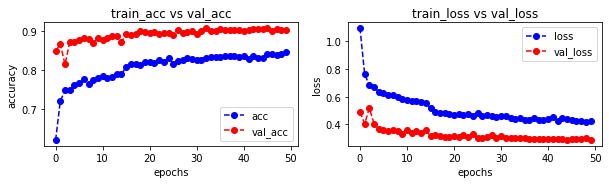

In [ ]:
plot_accuracy_loss(hist)

In [ ]:
model.evaluate(val_data[0],val_data[1])

41/41 [==============================] - 11s 190ms/step - loss: 0.2996 - acc: 0.9074


[0.2995922565460205, 0.9074074029922485]

In [ ]:
pred_labels = model.predict(val_data[0])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

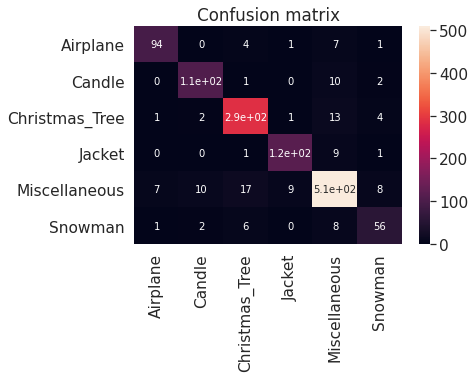

In [ ]:
CM = confusion_matrix(val_data[1].argmax(axis=1), pred_labels.argmax(axis=1))
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=[class_to_id[i] for i in range(6)], 
           yticklabels=[class_to_id[i] for i in range(6)], ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1 = f1_score(val_data[1].argmax(axis=1), pred_labels.argmax(axis=1),average='weighted')

In [ ]:
f1

0.9026839260834532

#for output subission

In [ ]:
#import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/projects/classification/assets/ckpt1000')


In [ ]:
model.evaluate(val_data[0],val_data[1])

41/41 [==============================] - 39s 796ms/step - loss: 0.2996 - acc: 0.9074


[0.2995927929878235, 0.9074074029922485]

In [ ]:
pred_labels = model.predict(val_data[0])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

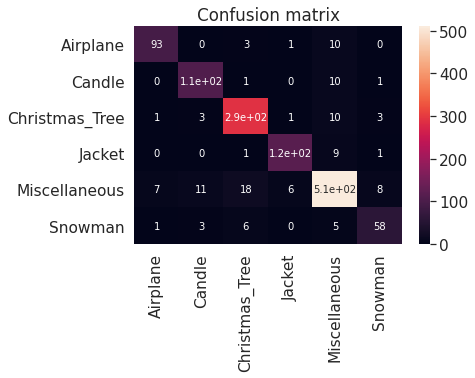

In [ ]:
CM = confusion_matrix(val_data[1].argmax(axis=1), pred_labels.argmax(axis=1))
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=[class_to_id[i] for i in range(6)], 
           yticklabels=[class_to_id[i] for i in range(6)], ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1 = f1_score(val_data[1].argmax(axis=1), pred_labels.argmax(axis=1),average='weighted')

In [ ]:
f1

0.9073115232686444

In [ ]:
test_path = "/content/dataset/test"
out_list = []
count = 0
errorimg = []
for dirpath, dirnames, filenames in os.walk(test_path):
    #print(dirpath, dirnames, filenames)
    for img_path in filenames:
        try:
            img = plt.imread(os.path.join(dirpath,img_path))
            
            if len(img.shape)==2:
                # 1 to 3 chennels
                img = cv2.merge((img,img,img))
            elif img.shape[2] ==4:
                #remove the alpha chennel
                img = img[:,:,:3]
            img= tf.image.resize(img,img_size)
            img = img/255.
            #plt.imshow(img)
            pred = model.predict(tf.reshape(img,(1,img.shape[0],img.shape[1],img.shape[2])))
            lable = class_to_id[pred[0].argmax()]
            out_list.append([img_path,lable])
            
            count+=1
        
            if count % 100 ==0:
                print(count,end="\t")
        except Exception as e:
            print(e)
            errorimg.append(img_path)
            out_list.append([img_path,'Miscellaneous'])
    break



name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to_id' is not defined
name 'class_to

KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame(out_list, columns=["Image","Class"]) 

In [ ]:
df.head()

,Image,Class
0,image750.jpg,Miscellaneous
1,image3305.jpg,Miscellaneous
2,image9446.jpg,Miscellaneous
3,image4309.jpg,Jacket
4,image8279.jpg,Christmas_Tree


In [ ]:
import datetime

date_time = datetime.datetime.now()

In [ ]:
print(date_time)

2021-02-09 12:58:12.918331


In [ ]:
df.to_csv(f'sub_{date_time.strftime("%d%b_%H_%M")}.csv', index=False)

In [ ]:
from google.colab import files
files.download(f'sub_{date_time.strftime("%d%b_%H_%M")}.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
m3.evaluate(val_data[0],val_data[1])

41/41 [==============================] - 10s 190ms/step - loss: 0.2848 - acc: 0.9043


[0.28476202487945557, 0.904321014881134]